In [7]:
import os
import time
from meidic_vtach_utils.run_on_recommended_cuda import get_cuda_environ_vars as get_vars
os.environ.update(get_vars(select="* -3 -4"))

from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.cuda.amp as amp
import torchvision
from curriculum_deeplab.data_parameters import DataParamMode
import torchio as tio

import matplotlib.pyplot as plt
from IPython.display import display
import nibabel as nib
from torch.utils.checkpoint import checkpoint

from sklearn.model_selection import KFold

from mdl_seg_class.metrics import dice3d, dice2d
from mdl_seg_class.visualization import display_seg
from curriculum_deeplab.mindssc import mindssc

from pathlib import Path

import wandb
import random
import glob
import re
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import numpy as np

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd

print(torch.__version__)
print(torch.backends.cudnn.version())
print(torch.cuda.get_device_name(0))


### Recommended gpus on this machine (descending order) ###
  ID  Card name                     Util    Mem free  Cuda             User(s)
----  --------------------------  ------  ----------  ---------------  ---------
   0  NVIDIA GeForce RTX 2080 Ti     0 %   11018 MiB  11.5(495.29.05)
   2  NVIDIA GeForce RTX 2080 Ti     0 %   11018 MiB  11.5(495.29.05)
   3  NVIDIA GeForce RTX 2080 Ti     0 %   11018 MiB  11.5(495.29.05)
   1  NVIDIA GeForce RTX 2080 Ti     0 %   11016 MiB  11.5(495.29.05)

Will apply following mapping

  ID  Card name                       torch
----  --------------------------  --  -------
   0  NVIDIA GeForce RTX 2080 Ti  ->  cuda:0
1.9.1+cu102
7605
NVIDIA GeForce RTX 2080 Ti


In [8]:
def in_notebook():
    try:
        get_ipython().__class__.__name__
        return True
    except NameError:
        return False
    
if in_notebook:
    THIS_SCRIPT_DIR = os.path.abspath('')
else:    
    THIS_SCRIPT_DIR = os.path.dirname(os.path.realpath(__file__))
print(f"Running in: {THIS_SCRIPT_DIR}")

Running in: /share/data_supergrover1/weihsbach/shared_data/tmp/curriculum_deeplab


In [9]:
def interpolate_sample(b_image, b_label, scale_factor, yield_2d):
    if yield_2d:
        scale = [scale_factor]*2
        im_mode = 'bilinear'
    else:
        scale = [scale_factor]*3
        im_mode = 'trilinear'

    b_image = F.interpolate(
        b_image.unsqueeze(1), scale_factor=scale, mode=im_mode, align_corners=True,
        recompute_scale_factor=False
    )

    b_label = F.interpolate(
        b_label.unsqueeze(1).float(), scale_factor=scale, mode='nearest',
        recompute_scale_factor=False
    ).long()

    return b_image.squeeze(1), b_label.squeeze(1)



def dilate_label_class(b_label, class_max_idx, class_dilate_idx,
                       yield_2d, kernel_sz=3):

    if kernel_sz < 2:
        return b_label

    b_dilated_label = b_label

    b_onehot = torch.nn.functional.one_hot(b_label.long(), class_max_idx+1)
    class_slice = b_onehot[...,class_dilate_idx]

    if yield_2d:
        B, H, W = class_slice.shape
        kernel = torch.ones([kernel_sz,kernel_sz]).long()
        kernel = kernel.view(1,1,kernel_sz,kernel_sz)
        class_slice = torch.nn.functional.conv2d(
            class_slice.view(B,1,H,W), kernel, padding='same')

    else:
        B, D, H, W = class_slice.shape
        kernel = torch.ones([kernel_sz,kernel_sz,kernel_sz])
        kernel = kernel.long().view(1,1,kernel_sz,kernel_sz,kernel_sz)
        class_slice = torch.nn.functional.conv3d(
            class_slice.view(B,1,D,H,W), kernel, padding='same')

    dilated_class_slice = torch.clamp(class_slice.squeeze(0), 0, 1)
    b_dilated_label[dilated_class_slice.bool()] = class_dilate_idx

    return b_dilated_label


def get_batch_dice_per_class(b_dice, class_tags, exclude_bg=True) -> dict:
    score_dict = {}
    for cls_idx, cls_tag in enumerate(class_tags):
        if exclude_bg and cls_idx == 0:
            continue

        if torch.all(torch.isnan(b_dice[:,cls_idx])):
            score = float('nan')
        else:
            score = np.nanmean(b_dice[:,cls_idx]).item()

        score_dict[cls_tag] = score

    return score_dict

def get_batch_dice_over_all(b_dice, exclude_bg=True) -> float:

    start_idx = 1 if exclude_bg else 0
    if torch.all(torch.isnan(b_dice[:,start_idx:])):
        return float('nan')
    return np.nanmean(b_dice[:,start_idx:]).item()



def get_2d_stack_batch_size(b_input_size: torch.Size, stack_dim):
    assert len(b_input_size) == 5, f"Input size must be 5D: BxCxDxHxW but is {b_input_size}"
    if stack_dim == "D":
        return b_input_size[0]*b_input_size[2]
    if stack_dim == "H":
        return b_input_size[0]*b_input_size[3]
    if stack_dim == "W":
        return b_input_size[0]*b_input_size[4]
    else:
        raise ValueError(f"stack_dim '{stack_dim}' must be 'D' or 'H' or 'W'.")



def make_2d_stack_from_3d(b_input, stack_dim):
    assert b_input.dim() == 5, f"Input must be 5D: BxCxDxHxW but is {b_input.shape}"
    B, C, D, H, W = b_input.shape

    if stack_dim == "D":
        return b_input.permute(0, 2, 1, 3, 4).reshape(B*D, C, H, W)
    if stack_dim == "H":
        return b_input.permute(0, 3, 1, 2, 4).reshape(B*H, C, D, W)
    if stack_dim == "W":
        return b_input.permute(0, 4, 1, 2, 3).reshape(B*W, C, D, H)
    else:
        raise ValueError(f"stack_dim '{stack_dim}' must be 'D' or 'H' or 'W'.")



def make_3d_from_2d_stack(b_input, stack_dim, orig_stack_size):
    assert b_input.dim() == 4, f"Input must be 4D: (orig_batch_size/B)xCxSPAT1xSPAT0 but is {b_input.shape}"
    B, C, SPAT1, SPAT0 = b_input.shape
    b_input = b_input.reshape(orig_stack_size, int(B//orig_stack_size), C, SPAT1, SPAT0)

    if stack_dim == "D":
        return b_input.permute(0, 2, 1, 3, 4)
    if stack_dim == "H":
        return b_input.permute(0, 2, 3, 1, 4)
    if stack_dim == "W":
        return b_input.permute(0, 2, 3, 4, 1)
    else:
        raise ValueError(f"stack_dim is '{stack_dim}' but must be 'D' or 'H' or 'W'.")

In [10]:
def spatial_augment(b_image, b_label,
    bspline_num_ctl_points=6, bspline_strength=0.005, bspline_probability=.9,
    affine_strengh=0.08, affine_probability=.45,
    pre_interpolation_factor=None,
    yield_2d=False):
    """
    2D/3D b-spline augmentation on image and segmentation mini-batch on GPU.
    :input: b_image batch (torch.cuda.FloatTensor), b_label batch (torch.cuda.LongTensor)
    :return: augmented Bx(D)xHxW image batch (torch.cuda.FloatTensor),
    augmented Bx(D)xHxW seg batch (torch.cuda.LongTensor)
    """

    do_bspline = (np.random.rand() < bspline_probability)
    do_affine = (np.random.rand() < affine_probability)

    if pre_interpolation_factor:
        b_image, b_label = interpolate_sample(b_image, b_label, pre_interpolation_factor, yield_2d)

    KERNEL_SIZE = 3

    if yield_2d:
        assert b_image.dim() == b_label.dim() == 3, \
            f"Augmenting 2D. Input batch of image and " \
            f"label should be BxHxW but are {b_image.shape} and {b_label.shape}"
        B,H,W = b_image.shape

        identity = torch.eye(2,3).expand(B,2,3).to(b_image.device)
        id_grid = F.affine_grid(identity, torch.Size((B,2,H,W)),
            align_corners=False)

        grid = id_grid

        if do_bspline:
            bspline = torch.nn.Sequential(
                nn.AvgPool2d(KERNEL_SIZE,stride=1,padding=int(KERNEL_SIZE//2)),
                nn.AvgPool2d(KERNEL_SIZE,stride=1,padding=int(KERNEL_SIZE//2)),
                nn.AvgPool2d(KERNEL_SIZE,stride=1,padding=int(KERNEL_SIZE//2))
            ).to(b_image.device)
            # Add an extra *.5 factor to dim strength to make strength fit 3D case
            dim_strength = (torch.tensor([H,W]).float()*bspline_strength*.5).to(b_image.device)
            rand_control_points = dim_strength.view(1,2,1,1) * torch.randn(
                B, 2, bspline_num_ctl_points, bspline_num_ctl_points
            ).to(b_image.device)

            bspline_disp = bspline(rand_control_points)
            bspline_disp = torch.nn.functional.interpolate(
                bspline_disp, size=(H,W), mode='bilinear', align_corners=True
            ).permute(0,2,3,1)

            grid += bspline_disp

        if do_affine:
            affine_matrix = (torch.eye(2,3).unsqueeze(0) + torch.randn(B,2,3) \
                            * affine_strengh).to(b_image.device)

            affine_disp = F.affine_grid(affine_matrix, torch.Size((B,1,H,W)),
                                    align_corners=False)
            grid += (affine_disp-id_grid)

    else:
        assert b_image.dim() == b_label.dim() == 4, \
            f"Augmenting 3D. Input batch of image and " \
            f"label should be BxDxHxW but are {b_image.shape} and {b_label.shape}"
        B,D,H,W = b_image.shape

        identity = torch.eye(3,4).expand(B,3,4).to(b_image.device)
        id_grid = F.affine_grid(identity, torch.Size((B,3,D,H,W)),
            align_corners=False)

        grid = id_grid

        if do_bspline:
            bspline = torch.nn.Sequential(
                nn.AvgPool3d(KERNEL_SIZE,stride=1,padding=int(KERNEL_SIZE//2)),
                nn.AvgPool3d(KERNEL_SIZE,stride=1,padding=int(KERNEL_SIZE//2)),
                nn.AvgPool3d(KERNEL_SIZE,stride=1,padding=int(KERNEL_SIZE//2))
            ).to(b_image.device)
            dim_strength = (torch.tensor([D,H,W]).float()*bspline_strength).to(b_image.device)

            rand_control_points = dim_strength.view(1,3,1,1,1) * torch.randn(
                B, 3, bspline_num_ctl_points, bspline_num_ctl_points, bspline_num_ctl_points
            ).to(b_image.device)

            bspline_disp = bspline(rand_control_points)

            bspline_disp = torch.nn.functional.interpolate(
                bspline_disp, size=(D,H,W), mode='trilinear', align_corners=True
            ).permute(0,2,3,4,1)

            grid += bspline_disp

        if do_affine:
            affine_matrix = (torch.eye(3,4).unsqueeze(0) + torch.randn(B,3,4) \
                    * affine_strengh).to(b_image.device)

            affine_disp = F.affine_grid(affine_matrix,torch.Size((B,1,D,H,W)),
                                    align_corners=False)

            grid += (affine_disp-id_grid)

    b_image_out = F.grid_sample(
        b_image.unsqueeze(1).float(), grid,
        padding_mode='border', align_corners=False)
    b_label_out = F.grid_sample(
        b_label.unsqueeze(1).float(), grid,
        mode='nearest', align_corners=False)

    b_image_out, b_label_out = b_image_out.squeeze(1), b_label_out.squeeze(1).long()

    if pre_interpolation_factor:
        b_image_out, b_label_out = interpolate_sample(
            b_image_out, b_label_out,
            1/pre_interpolation_factor, yield_2d
        )

    return b_image_out, b_label_out



def augmentNoise(b_image, strength=0.05):
    return b_image + strength*torch.randn_like(b_image)

In [11]:

class CrossMoDa_Data(Dataset):
    def __init__(self,
        base_dir, domain, state,
        ensure_labeled_pairs=True, use_additional_data=False, resample=True,
        size:tuple=(96,96,60), normalize:bool=True,
        max_load_num=None, crop_w_dim_range=None,
        disturbed_idxs=None, yield_2d_normal_to=None, flip_r_samples=True,
        dilate_kernel_sz=3,
        debug=False
    ):

        """
        Function to create Dataset structure with crossMoDa data.
        The function allows to use different preproccessing steps of the crossMoDa data set
        and using additinal data from TCIA database.
        The data can also be resampled to a desired size and normalized to mean=0 and std=1.

        Parameters:
                base_dir (os.Pathlike): provide the directory which contains "L1..." to "L4..." directories
                domain (str): choose which domain to load. Can be set to "source", "target" or "validation". Source are ceT1, target and validation hrT2 images.

                state (str): state of preprocessing:    "l1" = original data,
                                                        "l2" = resampled data @ 0.5mm,
                                                        "l3" = center-cropped data,
                                                        "l4" = image specific crops for desired anatomy

                ensure_labeled_pairs (bool): Only images with corresponding labels will be loaded (default: True)

                use_additional_data (bool): set to True to use additional data from TCIA (default: False)

                resample (bool): set to False to disable resampling to desired size (default: True)

                size (tuple): 3d-tuple(int) to which the data is resampled. Unused if resample=False. (default: (96,96,60)).
                    WARNING: choosing large sizes or not resampling can lead to excess memory usage

                normalize (bool): set to False to disable normalization to mean=0, std=1 for each image (default: True)
                max_load_num (int): maximum number of pairs to load (uses first max_load_num samples for either images and labels found)
                crop_w_dim_range (tuple): Tuple of ints defining the range to which dimension W of (D,H,W) is cropped
                yield_2d_normal_to (bool):

        Returns:
                torch.utils.data.Dataset containing CrossMoDa data

        Useful Links:
        CrossMoDa challenge:
        https://crossmoda.grand-challenge.org/

        ToDos:
            extend to other preprocessing states

        Example:
            dataset = CrossMoDa_source('original')

            data = dataset.get_data()

        """

        self.disturbed_idxs = disturbed_idxs
        self.yield_2d_normal_to = yield_2d_normal_to
        self.do_train = False
        self.augment_at_collate = False
        self.dilate_kernel_sz = dilate_kernel_sz

        #define finished preprocessing states here with subpath and default size
        states = {
            'l1':('L1_original/', (512,512,160)),
            'l2':('L2_resampled_05mm/', (420,420,360)),
            'l3':('L3_coarse_fixed_crop/', (128,128,192)),
            'l4':('L4_fine_localized_crop/', (128,128,128))
        }
        t0 = time.time()
        #choose directory with data according to chosen preprocessing state
        if state not in states: raise Exception("Unknown state. Choose one of: "+str(states.keys))

        state_dir = states[state.lower()][0] #get sub directory

        if not resample: size = states[state.lower()][1] #set size to default defined at top of file

        path = base_dir + state_dir

        #get file list
        if domain.lower() =="ceT1" or domain.lower() =="source":
            directory = "source_training_labeled/"
            add_directory = "__additional_data_source_domain__"
            domain = "ceT1"

        elif domain.lower() =="hrT2" or domain.lower() =="target":
            directory = "target_training_unlabeled/"
            add_directory = "__additional_data_target_domain__"
            domain = "hrT2"

        elif domain.lower() =="validation":
            directory = "target_validation_unlabeled/"

        else:
            raise Exception("Unknown domain. Choose either 'source', 'target' or 'validation'")

        files = sorted(glob.glob(os.path.join(path+directory , "*.nii.gz")))

        if domain == "hrT2":
            files = files+sorted(glob.glob(os.path.join(path+"__omitted_labels_target_training__" , "*.nii.gz")))

        if domain.lower() == "validation":
            files = files+sorted(glob.glob(os.path.join(path+"__omitted_labels_target_validation__" , "*.nii.gz")))

        if use_additional_data and domain.lower() != "validation": #add additional data to file list
            files = files+sorted(glob.glob(os.path.join(path+add_directory , "*.nii.gz")))
            files = [i for i in files if "additionalLabel" not in i] #remove additional label files

        # First read filepaths
        self.img_paths = {}
        self.label_paths = {}

        if debug:
            files = files[:4]

        for _path in files:

            numeric_id = int(re.findall(r'\d+', os.path.basename(_path))[0])
            if "_l.nii.gz" in _path or "_l_Label.nii.gz" in _path:
                lr_id = 'l'
            elif "_r.nii.gz" in _path or "_r_Label.nii.gz" in _path:
                lr_id = 'r'
            else:
                lr_id = ""

            # Generate crossmoda id like 004r
            crossmoda_id = f"{numeric_id:03d}{lr_id}"

            if "Label" in _path:
                self.label_paths[crossmoda_id] = _path

            elif domain in _path:
                self.img_paths[crossmoda_id] = _path

        if ensure_labeled_pairs:
            pair_idxs = set(self.img_paths).intersection(set(self.label_paths))
            self.label_paths = {_id: _path for _id, _path in self.label_paths.items() if _id in pair_idxs}
            self.img_paths = {_id: _path for _id, _path in self.img_paths.items() if _id in pair_idxs}


        # Populate data
        self.img_data_3d = {}
        self.label_data_3d = {}

        self.img_data_2d = {}
        self.label_data_2d = {}

        #load data

        print("Loading CrossMoDa {} images and labels...".format(domain))
        id_paths_to_load = list(self.label_paths.items()) + list(self.img_paths.items())

        description = f"{len(self.img_paths)} images, {len(self.label_paths)} labels"

        for _3d_id, _file in tqdm(id_paths_to_load, desc=description):
            # tqdm.write(f"Loading {f}")
            if "Label" in _file:
                tmp = torch.from_numpy(nib.load(_file).get_fdata())
                if resample: #resample image to specified size
                    tmp = F.interpolate(tmp.unsqueeze(0).unsqueeze(0), size=size,mode='nearest').squeeze()

                if tmp.shape != size: #for size missmatch use symmetric padding with 0
                    difs = [size[0]-tmp.size(0),size[1]-tmp.size(1),size[2]-tmp.size(2)]
                    pad = (difs[-1]//2,difs[-1]-difs[-1]//2,difs[-2]//2,difs[-2]-difs[-2]//2,difs[-3]//2,difs[-3]-difs[-3]//2)
                    tmp = F.pad(tmp,pad)

                if crop_w_dim_range:
                    tmp = tmp[..., crop_w_dim_range[0]:crop_w_dim_range[1]]

                # Only use tumour class, remove TODO
                tmp[tmp==2] = 0
                self.label_data_3d[_3d_id] = tmp.long()

            elif domain in _file:
                tmp = torch.from_numpy(nib.load(_file).get_fdata())
                if resample: #resample image to specified size
                    tmp = F.interpolate(tmp.unsqueeze(0).unsqueeze(0), size=size,mode='trilinear',align_corners=False).squeeze()

                if tmp.shape != size: #for size missmatch use symmetric padding with 0
                    difs = [size[0]-tmp.size(0),size[1]-tmp.size(1),size[2]-tmp.size(2)]
                    pad = (difs[-1]//2,difs[-1]-difs[-1]//2,difs[-2]//2,difs[-2]-difs[-2]//2,difs[-3]//2,difs[-3]-difs[-3]//2)
                    tmp = F.pad(tmp,pad)

                if crop_w_dim_range:
                    tmp = tmp[..., crop_w_dim_range[0]:crop_w_dim_range[1]]

                if normalize: #normalize image to zero mean and unit std
                    tmp = (tmp - tmp.mean()) / tmp.std()

                self.img_data_3d[_3d_id] = tmp

        # Postprocessing
        for _3d_id in list(self.label_data_3d.keys()):
            if self.label_data_3d[_3d_id].unique().numel() != 2: #TODO use 3 classes again
                del self.img_data_3d[_3d_id]
                del self.label_data_3d[_3d_id]
            elif "r" in _3d_id:
                self.img_data_3d[_3d_id] = self.img_data_3d[_3d_id].flip(dims=(1,))
                self.label_data_3d[_3d_id] = self.label_data_3d[_3d_id].flip(dims=(1,))

        if max_load_num and ensure_labeled_pairs:
            for _3d_id in list(self.label_data_3d.keys())[max_load_num:]:
                del self.img_data_3d[_3d_id]
                del self.label_data_3d[_3d_id]

        elif max_load_num:
            for del_key in list(self.img_data_3d.keys())[max_load_num:]:
                del self.img_data_3d[del_key]
            for del_key in list(self.label_data_3d.keys())[max_load_num:]:
                del self.label_data_3d[del_key]

        #check for consistency
        print("Equal image and label numbers: {}".format(set(self.img_data_3d)==set(self.label_data_3d)))

        img_stack = torch.stack(list(self.img_data_3d.values()), dim=0)
        img_mean, img_std = img_stack.mean(), img_stack.std()

        label_stack = torch.stack(list(self.label_data_3d.values()), dim=0)

        print("Image shape: {}, mean.: {:.2f}, std.: {:.2f}".format(img_stack.shape, img_mean, img_std))
        print("Label shape: {}, max.: {}".format(label_stack.shape,torch.max(label_stack)))

        if yield_2d_normal_to:
            if yield_2d_normal_to == "D":
                slice_dim = -3
            if yield_2d_normal_to == "H":
                slice_dim = -2
            if yield_2d_normal_to == "W":
                slice_dim = -1

            for _3d_id, image in self.img_data_3d.items():
                for idx, img_slc in [(slice_idx, image.select(slice_dim, slice_idx)) \
                                     for slice_idx in range(image.shape[slice_dim])]:
                    # Set data view for crossmoda id like "003rW100"
                    self.img_data_2d[f"{_3d_id}{yield_2d_normal_to}{idx:03d}"] = img_slc

            for _3d_id, label in self.label_data_3d.items():
                for idx, lbl_slc in [(slice_idx, label.select(slice_dim, slice_idx)) \
                                     for slice_idx in range(label.shape[slice_dim])]:
                    # Set data view for crossmoda id like "003rW100"
                    self.label_data_2d[f"{_3d_id}{yield_2d_normal_to}{idx:03d}"] = lbl_slc

        # Delete empty 2D slices (but keep 3d data)
        for key, label in list(self.label_data_2d.items()):
            if label.unique().numel() < 2:
                del self.label_data_2d[key]
                del self.img_data_2d[key]


        print("Data import finished.")
        print(f"CrossMoDa loader will yield {'2D' if self.yield_2d_normal_to else '3D'} samples")

    def get_3d_ids(self):
        return sorted(list(
            set(self.img_data_3d.keys())
            .union(set(self.label_data_3d.keys()))
        ))

    def get_2d_ids(self):
        return sorted(list(
            set(self.img_data_2d.keys())
            .union(set(self.label_data_2d.keys()))
        ))

    def get_id_dicts(self):

        all_3d_ids = self.get_3d_ids()
        id_dicts = []

        for _2d_dataset_idx, _2d_id in enumerate(self.get_2d_ids()):
            _3d_id = _2d_id[:-4]
            id_dicts.append(
                {
                    '2d_id': _2d_id,
                    '2d_dataset_idx': _2d_dataset_idx,
                    '3d_id': _3d_id,
                    '3d_dataset_idx': all_3d_ids.index(_3d_id),
                }
            )

        return id_dicts

    def __len__(self, yield_2d_override=None):
        if yield_2d_override == None:
            # Here getting 2D or 3D data length
            yield_2d = True if self.yield_2d_normal_to else False
        else:
            yield_2d = yield_2d_override

        if yield_2d:
            return len(self.img_data_2d)

        return len(self.img_data_3d)

    def __getitem__(self, dataset_idx, yield_2d_override=None):

        if yield_2d_override == None:
            # Here getting 2D or 3D data can be overridden
            yield_2d = True if self.yield_2d_normal_to else False
        else:
            yield_2d = yield_2d_override

        modified_label = []

        if yield_2d:
            all_ids = self.get_2d_ids()
            _id = all_ids[dataset_idx]
            image = self.img_data_2d.get(_id, torch.tensor([]))
            label = self.label_data_2d.get(_id, torch.tensor([]))

            # For 2D crossmoda id cut last 4 "003rW100"
            image_path = self.img_paths[_id[:-4]]
            label_path = self.label_paths[_id[:-4]]

        else:
            all_ids = self.get_3d_ids()
            _id = all_ids[dataset_idx]
            image = self.img_data_3d.get(_id, torch.tensor([]))
            label = self.label_data_3d.get(_id, torch.tensor([]))

            image_path = self.img_paths[_id]
            label_path = self.label_paths[_id]

        if self.do_train:
            # In case of training add augmentation, modification and
            # disturbance

            if not self.augment_at_collate:
                b_image = image.unsqueeze(0).cuda()
                b_label = label.unsqueeze(0).cuda()
                b_image, b_label = self.augment(b_image, b_label, yield_2d)
                image = b_image.squeeze(0).cpu()
                label = b_label.squeeze(0).cpu()

            # Dilate small cochlea segmentation
            # COCHLEA_CLASS_IDX = 2
            # pre_mod = b_label.squeeze(0)
            # modified_label = dilate_label_class(
            #     b_label.detach().clone(), COCHLEA_CLASS_IDX, COCHLEA_CLASS_IDX,
            #     yield_2d=yield_2d, kernel_sz=self.dilate_kernel_sz
            # ).squeeze(0)
            modified_label = label.detach().clone()

            if self.disturbed_idxs != None and dataset_idx in self.disturbed_idxs:
                with torch_manual_seeded(dataset_idx):
                    ROLL_FACT = 10
                    if yield_2d:
                        modified_label = \
                            torch.roll(
                                modified_label.transpose(-2,-1),
                                (
                                    int(torch.randn(1)*ROLL_FACT),
                                    int(torch.randn(1)*ROLL_FACT)
                                ),(-2,-1)
                            )
                            # torch.flip(modified_label, dims=(-2,-1))
                    else:
                        modified_label = \
                            torch.roll(
                                modified_label.permute(1,2,0),
                                (
                                    int(torch.randn(1)*ROLL_FACT),
                                    int(torch.randn(1)*ROLL_FACT),
                                    int(torch.randn(1)*ROLL_FACT)
                                ),(-3,-2,-1)
                            )
                            # torch.flip(modified_label, dims=(-3,-2,-1))

        if yield_2d:
            assert image.dim() == label.dim() == 2
        else:
            assert image.dim() == label.dim() == 3

        return {
            'image': image,
            'label': label,
            'modified_label': modified_label,
            'dataset_idx': dataset_idx,
            'id': _id,
            'image_path': image_path,
            'label_path': label_path
        }

    def get_3d_item(self, _3d_dataset_idx):
        return self.__getitem__(_3d_dataset_idx, yield_2d_override=False)

    def get_data(self, yield_2d_override=None):
        if yield_2d_override == None:
            # Here getting 2D or 3D data can be overridden
            yield_2d = True if self.yield_2d_normal_to else False
        else:
            yield_2d = yield_2d_override

        if yield_2d:
            img_stack = torch.stack(list(self.img_data_2d.values()), dim=0)
            label_stack = torch.stack(list(self.label_data_2d.values()), dim=0)
        else:
            img_stack = torch.stack(list(self.img_data_3d.values()), dim=0)
            label_stack = torch.stack(list(self.label_data_3d.values()), dim=0)

        return img_stack, label_stack

    def set_disturbed_idxs(self, idxs):
        if idxs is not None:
            if isinstance(idxs, (np.ndarray, torch.Tensor)):
                idxs = idxs.tolist()

            self.disturbed_idxs = idxs
        else:
            self.disturbed_idxs = []


    def train(self):
        self.do_train = True

    def eval(self):
        self.do_train = False

    def set_augment_at_collate(self):
        self.augment_at_collate = True

    def unset_augment_at_collate(self):
        self.augment_at_collate = False

    def set_dilate_kernel_size(self, sz):

        self.dilate_kernel_sz = max(1,sz)

    def get_dilate_kernel_size(self):
        return self.dilate_kernel_sz

    def get_efficient_augmentation_collate_fn(self):
        yield_2d = True if self.yield_2d_normal_to else False

        def collate_closure(batch):
            batch = torch.utils.data._utils.collate.default_collate(batch)
            if self.augment_at_collate:
                # Augment the whole batch not just one sample
                b_image = batch['image'].cuda()
                b_label = batch['label'].cuda()
                b_image, b_label = self.augment(b_image, b_label, yield_2d)
                batch['image'], batch['label'] = b_image.cpu(), b_label.cpu()

            return batch

        return collate_closure

    def augment(self, b_image, b_label, yield_2d):
        if yield_2d:
            assert b_image.dim() == b_label.dim() == 3, \
                f"Augmenting 2D. Input batch of image and " \
                f"label should be BxHxW but are {b_image.shape} and {b_label.shape}"
        else:
            assert b_image.dim() == b_label.dim() == 4, \
                f"Augmenting 3D. Input batch of image and " \
                f"label should be BxDxHxW but are {b_image.shape} and {b_label.shape}"

        b_image = augmentNoise(b_image, strength=0.05)
        b_image, b_label = spatial_augment(
            b_image, b_label,
            bspline_num_ctl_points=6, bspline_strength=0.004, bspline_probability=.95,
            affine_strengh=0.07, affine_probability=.45,
            pre_interpolation_factor=2., yield_2d=yield_2d)


        b_label = b_label.long()

        return b_image, b_label

    def augment_tio(self, image, label, yield_2d):
        # Prepare dims for torchio: All transformed
        # images / labels need to be 4-dim;
        # 2D images need to have dims=1xHxWx1 to make transformation work

        if yield_2d:
            assert image.dim() == label.dim() == 3, \
                f"Augmenting 2D. Input batch of image and " \
                f"label should be 1xHxW but are {image.shape} and {label.shape}"
        else:
            assert image.dim() == label.dim() == 4, \
                f"Augmenting 3D. Input batch of image and " \
                f"label should be 1xDxHxW but are {image.shape} and {label.shape}"

        if self.yield_2d_normal_to:
            self.spatial_transform = tio.OneOf({
                tio.transforms.RandomAffine(.05): 0.8,
                tio.transforms.RandomElasticDeformation(num_control_points=7, max_displacement=(7.5,7.5,1e-5)): 0.2,
                },
                p=0.75,
            )
        else:
            self.spatial_transform = tio.OneOf({
                tio.transforms.RandomAffine(.05): 0.8,
                tio.transforms.RandomElasticDeformation(num_control_points=7, max_displacement=7.5): 0.2,
                },
                p=0.75,
            )

        # Transforms can be composed as in torchvision.transforms
        self.intensity_transform = tio.OneOf({
            tio.transforms.RandomNoise(std=0.05): 0.6,
        })

        if yield_2d:
            image = image.unsqueeze(-1)
            label = label.unsqueeze(-1)


        # Run torchio transformation - LabelMap will be secured for intensity
        # transformations
        subject = tio.Subject(
            image=tio.ScalarImage(tensor=image),
            label=tio.LabelMap(tensor=label)
        )
        subject = self.spatial_transform(subject)
        # Transform image intensities apart from subject - spatial transform
        # was not applied to label correctly if transformations are stacked.
        image = self.intensity_transform(subject.image).data
        image = subject.image.data
        label = subject.label.data

        if yield_2d:
            image = image.squeeze(-1)
            label = label.squeeze(-1)

        label = label.long()

        return image, label
    

from contextlib import contextmanager

@contextmanager
def torch_manual_seeded(seed):
    saved_state = torch.get_rng_state()
    torch.manual_seed(seed)
    yield
    torch.set_rng_state(saved_state)

In [54]:
class DotDict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

config_dict = DotDict({
    'num_folds': 3,
    'only_first_fold': True,
    # 'fold_override': 0,
    # 'epx_override': 0,

    'num_classes': 3,
    'use_mind': True,
    'epochs': 120,

    'batch_size': 64,
    'val_batch_size': 1,

    'dataset': 'crossmoda',
    'train_set_max_len': 100,
    'crop_w_dim_range': (24, 110),
    'yield_2d_normal_to': "W",

    'lr': 0.0005,
    'use_cosine_annealing': True,

    # Data parameter config
    'data_parameter_config': DotDict(
        data_param_mode=DataParamMode.ONLY_INSTANCE_PARAMS,
        # init_class_param=0.01,
        # lr_class_param=0.1,
        init_inst_param=1.0,
        lr_inst_param=0.1,
        # wd_inst_param=0.0,
        # wd_class_param=0.0,
        # skip_clamp_data_param=False,
        # clamp_sigma_min=np.log(1/20),
        # clamp_sigma_max=np.log(20),
        # optim_algorithm=DataParamOptim.ADAM,
        # optim_options=dict(
        #     betas=(0.9, 0.999)
        # )
    ),

    'save_every': 60,
    'mdl_save_prefix': 'data/models',

    'do_plot': False,
    'debug': bool(int(os.environ.get('PYTHON_DEBUG', "1"))),
    'wandb_mode': os.environ.get('WANDB_MODE', "online"),
    'wandb_name_override': 'my-name',

    'disturbed_percentage': .3,
    'start_disturbing_after_ep': 0,

    'start_dilate_kernel_sz': 1
})

In [55]:
if config_dict['dataset'] == 'crossmoda':
    training_dataset = CrossMoDa_Data("/share/data_supergrover1/weihsbach/shared_data/tmp/CrossMoDa/",
        domain="source", state="l4", size=(128, 128, 128),
        ensure_labeled_pairs=True,
        max_load_num=config_dict['train_set_max_len'],
        crop_w_dim_range=config_dict['crop_w_dim_range'],
        yield_2d_normal_to=config_dict['yield_2d_normal_to'],
        dilate_kernel_sz=config_dict['start_dilate_kernel_sz'],
        debug=config_dict['debug']
    )
    config_dict['label_tags'] = ['background', 'tumour']
    print("Nonzero slice ratio: ",
        sum([b['label'].unique().numel() > 1 for b in training_dataset])/len(training_dataset)
    )
    # validation_dataset = CrossMoDa_Data("/share/data_supergrover1/weihsbach/shared_data/tmp/CrossMoDa/",
    #     domain="validation", state="l4", ensure_labeled_pairs=True)
    # target_dataset = CrossMoDa_Data("/share/data_supergrover1/weihsbach/shared_data/tmp/CrossMoDa/",
    #     domain="target", state="l4", ensure_labeled_pairs=True)

elif config_dict['dataset'] == 'organmnist3d':
    training_dataset = WrapperOrganMNIST3D(
        split='train', root='./data/medmnist', download=True, normalize=True,
        max_load_num=300, crop_w_dim_range=None,
        disturbed_idxs=None, yield_2d_normal_to='W'
    )
    print(training_dataset.mnist_set.info)
    label_tags = list(training_dataset.mnist_set.info['label'].values())
    config_dict['label_tags'] = label_tags
    print("Classes: ", label_tags)
    print("Samples: ", len(training_dataset))

Loading CrossMoDa ceT1 images and labels...


2 images, 2 labels: 100%|█████████████████████████| 4/4 [00:00<00:00, 10.87it/s]

Equal image and label numbers: True
Image shape: torch.Size([1, 128, 128, 86]), mean.: -0.00, std.: 1.00
Label shape: torch.Size([1, 128, 128, 86]), max.: 1
Data import finished.
CrossMoDa loader will yield 2D samples
Nonzero slice ratio:  1.0


torch.Size([1, 128, 128, 86])


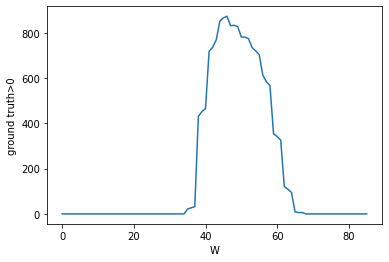

In [56]:
_, all_labels = training_dataset.get_data(yield_2d_override=False)
print(all_labels.shape)
sum_over_w = torch.sum(all_labels, dim=(0,1,2))
plt.xlabel("W")
plt.ylabel("ground truth>0")
plt.plot(sum_over_w);

In [57]:
if config_dict['do_plot']:
    # Print bare 2D data
    # print("Displaying 2D bare sample")
    # for img, label in zip(training_dataset.img_data_2d.values(),
    #                       training_dataset.label_data_2d.values()):
    #     display_seg(in_type="single_2D",
    #                 img=img.unsqueeze(0),
    #                 ground_truth=label,
    #                 crop_to_non_zero_gt=True,
    #                 alpha_gt = .3)

    # Print transformed 2D data
    training_dataset.train()
    print(training_dataset.disturbed_idxs)
    training_dataset.set_disturbed_idxs(list(range(0,40,3)))
    print("Displaying 2D training sample")
    for sample in (training_dataset[idx] for idx in range(40)):
        display_seg(in_type="single_2D",
                    img=sample['image'].unsqueeze(0),
                    ground_truth=sample['label'],
                    seg=sample['modified_label'],
                    crop_to_non_zero_gt=True,
                    crop_to_non_zero_seg=True,
                    alpha_seg = .2,
                    alpha_gt = .4)

#     # Print transformed 3D data
#     training_dataset.train()
#     print("Displaying 3D training sample")
#     leng = 1# training_dataset.__len__(yield_2d_override=False)
#     for sample in (training_dataset.get_3d_item(idx) for idx in range(leng)):
#         # training_dataset.set_dilate_kernel_size(1)
#         display_seg(in_type="single_3D", reduce_dim="W",
#                     img=sample['image'].unsqueeze(0),
#                     ground_truth=sample['label'],
#                     crop_to_non_zero_gt=True,
#                     alpha_gt = .3)

#         # training_dataset.set_dilate_kernel_size(7)
#         display_seg(in_type="single_3D", reduce_dim="W",
#                     img=sample['image'].unsqueeze(0),
#                     ground_truth=sample['modified_label'],
#                     crop_to_non_zero_gt=True,
#                     alpha_gt = .3)

In [58]:
if config_dict['do_plot']:
    for sidx in [1,]:
        print(f"Sample {sidx}:")

        training_dataset.eval()
        sample_eval = training_dataset.get_3d_item(sidx)

        display_seg(in_type="single_3D", reduce_dim="W",
                    img=sample_eval['image'].unsqueeze(0),
                    ground_truth=sample_eval['label'],
                    crop_to_non_zero_gt=True,
                    alpha_gt = .3)

        display_seg(in_type="single_3D", reduce_dim="W",
                    img=sample_eval['image'].unsqueeze(0),
                    ground_truth=sample_eval['label'],
                    crop_to_non_zero_gt=True,
                    alpha_gt = .0)

        training_dataset.train()
        print("Train sample with ground-truth overlay")
        sample_train = training_dataset.get_3d_item(sidx)
        print(sample_train['label'].unique())
        display_seg(in_type="single_3D", reduce_dim="W",
                    img=sample_train['image'].unsqueeze(0),
                    ground_truth=sample_train['label'],
                    crop_to_non_zero_gt=True,
                    alpha_gt=.3)

        print("Eval/train diff with diff overlay")
        display_seg(in_type="single_3D", reduce_dim="W",
                    img=(sample_eval['image'] - sample_train['image']).unsqueeze(0),
                    ground_truth=(sample_eval['label'] - sample_train['label']).clamp(min=0),
                    crop_to_non_zero_gt=True,
                    alpha_gt = .3)

In [59]:
# train_subset = torch.utils.data.Subset(training_dataset,range(2))
if config_dict['do_plot']:
    train_plotset = (training_dataset.get_3d_item(idx) for idx in (55, 81, 63))
    for sample in train_plotset:
        print(f"Sample {sample['dataset_idx']}:")
        display_seg(in_type="single_3D", reduce_dim="W",
            img=sample_eval['image'].unsqueeze(0),
            ground_truth=sample_eval['label'],
            crop_to_non_zero_gt=True,
            alpha_gt = .6)
        display_seg(in_type="single_3D", reduce_dim="W",
            img=sample_eval['image'].unsqueeze(0),
            ground_truth=sample_eval['label'],
            crop_to_non_zero_gt=True,
            alpha_gt = .0)

In [60]:
#Add functions to replace modules of a model

import functools
MOD_GET_FN = lambda self, key: self[int(key)] if isinstance(self, nn.Sequential) \
                                              else getattr(self, key)

def get_module(module, keychain):
    """Retrieves any module inside a pytorch module for a given keychain.
       module.named_ to retrieve valid keychains for layers.
    """

    return functools.reduce(MOD_GET_FN, keychain.split('.'), module)

def set_module(module, keychain, replacee):
    """Replaces any module inside a pytorch module for a given keychain with "replacee".
       Use get_named_layers_leaves(module) to retrieve valid keychains for layers.
    """

    key_list = keychain.split('.')
    root = functools.reduce(MOD_GET_FN, key_list[:-1], module)
    leaf = key_list[-1]
    if isinstance(root, nn.Sequential):
        root[int(leaf)] = replacee
    else:
        setattr(root, leaf, replacee)

In [79]:
def save_model(lraspp, optimizer, optimizer_dp, embedding, scaler, _path):
    _path = Path(THIS_SCRIPT_DIR).joinpath(_path).resolve()
    _path.mkdir(exist_ok=True, parents=True)
    
    torch.save(lraspp.state_dict(), _path.joinpath('lraspp.pth'))
    torch.save(optimizer.state_dict(), _path.joinpath('optimizer.pth'))
    torch.save(scaler.state_dict(), _path.joinpath('grad_scaler.pth'))
    torch.save(optimizer_dp.state_dict(), _path.joinpath('optimizer_dp.pth'))
    torch.save(embedding.state_dict(), _path.joinpath('embedding.pth'))
    


def get_model(config, dataset_len, _path=None, device='cpu'):
    _path = Path(THIS_SCRIPT_DIR).joinpath(_path).resolve()
    
    if config.use_mind:
        in_channels = 12
    else:
        in_channels = 1

    lraspp = torchvision.models.segmentation.lraspp_mobilenet_v3_large(
        pretrained=False, progress=True, num_classes=len(config.label_tags)
    )
    set_module(lraspp, 'backbone.0.0',
               torch.nn.Conv2d(in_channels, 16, kernel_size=(3, 3), stride=(2, 2),
                               padding=(1, 1), bias=False)
    )
    
    lraspp.to(device)
    
    optimizer = torch.optim.Adam(lraspp.parameters(), lr=config.lr)

    # Add data paramters
    embedding = nn.Embedding(len(training_dataset), 1, sparse=True).to(device)
    torch.nn.init.constant_(embedding.weight.data, config.data_parameter_config['init_inst_param'])

    optimizer_dp = torch.optim.SparseAdam(
        embedding.parameters(), lr=config.data_parameter_config['lr_inst_param'],
        betas=(0.9, 0.999), eps=1e-08)

    scaler = amp.GradScaler()

    if _path and _path.is_dir():
        print(f"Loading lr-aspp model, optimizers, embedding and grad scalers from {_path}")
        lraspp.load_state_dict(torch.load(_path.joinpath('lraspp.pth'), map_location=device))
        optimizer.load_state_dict(torch.load(_path.joinpath('optimizer.pth'), map_location=device))
        optimizer_dp.load_state_dict(torch.load(_path.joinpath('optimizer_dp.pth'), map_location=device))
        embedding.load_state_dict(torch.load(_path.joinpath('embedding.pth'), map_location=device))
        scaler.load_state_dict(torch.load(_path.joinpath('grad_scaler.pth'), map_location=device))
        
    else:
        print("Generating fresh lr-aspp model, optimizers, embedding and grad scaler.")

    return (lraspp, optimizer, optimizer_dp, embedding, scaler)

In [80]:
def get_global_idx(fold_idx, epoch_idx, max_epochs):
    # Get global index e.g. 2250 for fold_idx=2, epoch_idx=250 @ max_epochs<1000
    return 10**len(str(int(max_epochs)))*fold_idx + epoch_idx



def log_data_parameters(log_path, parameter_idxs, parameters):
    data = [[idx, param] for (idx, param) in \
        zip(parameter_idxs, torch.exp(parameters).tolist())]

    table = wandb.Table(data=data, columns = ["parameter_idx", "value"])
    wandb.log({log_path:wandb.plot.bar(table, "parameter_idx", "value", title=log_path)})



def calc_inst_parameters_in_target_pos_ratio(dpm, disturbed_inst_idxs, target_pos='min'):

    assert target_pos == 'min' or target_pos == 'max', "Value of target_pos must be 'min' or 'max'."
    descending = False if target_pos == 'min' else True

    target_len = len(disturbed_inst_idxs)

    disturbed_params = dpm.get_parameter_list(inst_keys=disturbed_inst_idxs)
    all_params = sorted(dpm.get_parameter_list(inst_keys='all'), reverse=descending)
    target_param_ids = [id(param) for param in all_params[:target_len]]

    ratio = [1. for param in disturbed_params if id(param) in target_param_ids]
    ratio = sum(ratio)/target_len
    return ratio

def log_data_parameter_stats(log_path, epx, data_parameters):
    """Log stats for data parameters on wandb."""
    data_parameters = data_parameters.exp()
    wandb.log({f'{log_path}/highest': torch.max(data_parameters).item()}, step=epx)
    wandb.log({f'{log_path}/lowest': torch.min(data_parameters).item()}, step=epx)
    wandb.log({f'{log_path}/mean': torch.mean(data_parameters).item()}, step=epx)
    wandb.log({f'{log_path}/std': torch.std(data_parameters).item()}, step=epx)



def reset_determinism():
    torch.manual_seed(0)
    random.seed(0)
    np.random.seed(0)
    # torch.use_deterministic_algorithms(True)




def log_class_dices(log_prefix, log_postfix, class_dices, log_idx):
    if not class_dices:
        return

    for cls_name in class_dices[0].keys():
        log_path = f"{log_prefix}{cls_name}{log_postfix}"

        cls_dices = list(map(lambda dct: dct[cls_name], class_dices))
        mean_per_class =np.nanmean(cls_dices)
        print(log_path, f"{mean_per_class*100:.2f}%")
        wandb.log({log_path: mean_per_class}, step=log_idx)

In [86]:
def train_DL(run_name, config, training_dataset):
    reset_determinism()

    # Configure folds
    kf = KFold(n_splits=config.num_folds)
    kf.get_n_splits(training_dataset)

    fold_iter = enumerate(kf.split(training_dataset))

    if config.get('fold_override', None):
        selected_fold = config.get('fold_override', 0)
        fold_iter = list(fold_iter)[selected_fold:selected_fold+1]
    elif config.only_first_fold:
        fold_iter = list(fold_iter)[0:1]

    if config.wandb_mode != 'disabled':
        # Log dataset info
        training_dataset.eval()
        dataset_info = [[smp['dataset_idx'], smp['id'], smp['image_path'], smp['label_path']] \
                        for smp in training_dataset]
        wandb.log({'datasets/training_dataset':wandb.Table(columns=['dataset_idx', 'id', 'image', 'label'], data=dataset_info)}, step=0)

    fold_means_no_bg = []

    for fold_idx, (train_idxs, val_idxs) in fold_iter:
        train_idxs = torch.tensor(train_idxs)
        val_idxs = torch.tensor(val_idxs)

        # Training happens in 2D, validation happens in 3D:
        # Read 2D dataset idxs which are used for training,
        # get their 3D super-ids by 3d dataset length
        # and substract these from all 3D ids to get val_3d_idxs
        trained_3d_dataset_idxs = {dct['3d_dataset_idx'] \
             for dct in training_dataset.get_id_dicts() if dct['2d_dataset_idx'] in train_idxs.tolist()}
        val_3d_idxs = set(range(training_dataset.__len__(yield_2d_override=False))) - trained_3d_dataset_idxs
        print("Will run validation with these 3D samples:", val_3d_idxs)

        ### Disturb dataset ###
        disturbed_idxs = np.random.choice(train_idxs, size=int(len(train_idxs)*config.disturbed_percentage), replace=False)
        disturbed_idxs = torch.tensor(disturbed_idxs)

        disturbed_bool_vect = torch.zeros(len(training_dataset))
        disturbed_bool_vect[disturbed_idxs] = 1.

        clean_idxs = train_idxs[np.isin(train_idxs, disturbed_idxs, invert=True)]
        print("Disturbed indexes:", sorted(disturbed_idxs.tolist()))

        if clean_idxs.numel() < 200:
            print(f"Clean indexes: {sorted(clean_idxs.tolist())}")

        wandb.log({f'datasets/disturbed_idxs_fold{fold_idx}':wandb.Table(columns=['train_idxs'], data=[[idx] for idx in disturbed_idxs])},
            step=get_global_idx(fold_idx, 0, config.epochs))

        ### Visualization ###
        if config.do_plot:
            print("Disturbed samples:")
            for d_idx in disturbed_idxs:
                display_seg(in_type="single_3D", reduce_dim="W",
                    img=training_dataset[d_idx][0],
                    ground_truth=disturb_seg(training_dataset[d_idx][1]),
                    crop_to_non_zero_gt=True,
                    alpha_gt = .0)

        ### Configure MIND ###
        if config.use_mind:
            in_channels =12
        else:
            in_channels = 1

        _, all_segs = training_dataset.get_data()

        # TODO add class weights again
        # class_weight = torch.sqrt(1.0/(torch.bincount(all_segs.long().view(-1)).float()))
        # class_weight = class_weight/class_weight.mean()
        # class_weight[0] = 0.15
        # class_weight = class_weight.cuda()
        # print('inv sqrt class_weight', class_weight)

        ### Add train sampler and dataloaders ##
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idxs)
        # val_subsampler = torch.utils.data.SubsetRandomSampler(val_idxs)

        train_dataloader = DataLoader(training_dataset, batch_size=config.batch_size,
            sampler=train_subsampler, pin_memory=True, drop_last=False,
            # collate_fn=training_dataset.get_efficient_augmentation_collate_fn()
        )
        training_dataset.unset_augment_at_collate()

#         val_dataloader = DataLoader(training_dataset, batch_size=config.val_batch_size,
#                                     sampler=val_subsampler, pin_memory=True, drop_last=False)

        ### Get model, data parameters, optimizers for model and data parameters, as well as grad scaler ###
        epx_start = config.get('epx_override', 0)
        _path = f"{config.mdl_save_prefix}/{wandb.run.name}_fold{fold_idx}_epx{epx_start}"
        (lraspp, optimizer, optimizer_dp, embedding, scaler) = get_model(config, len(train_dataloader), _path=_path)

        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer, T_0=200, T_mult=2, eta_min=config.lr*.1, last_epoch=- 1, verbose=False)

        criterion = nn.CrossEntropyLoss()
        _, all_segs = training_dataset.get_data()

        # Add inverse weighting to instances according to labeled pixels
        # instance_pixel_weight = torch.sqrt(1.0/(torch.stack([torch.bincount(seg.view(-1))[1] for seg in all_segs]).float()))  TODO removce
        # instance_pixel_weight = instance_pixel_weight/instance_pixel_weight.mean()  TODO removce
        torch.nn.init.constant_(embedding.weight.data, config.data_parameter_config['init_inst_param'])

        scheduler_dp = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer_dp, T_0=200, T_mult=2, eta_min=config.data_parameter_config['lr_inst_param']*.1, last_epoch=- 1, verbose=False)

        t0 = time.time()

        embedding = embedding.cuda()
        # instance_pixel_weight = instance_pixel_weight.cuda()
        lraspp.cuda()
        
        for epx in range(epx_start, config.epochs):
            global_idx = get_global_idx(fold_idx, epx, config.epochs)

            lraspp.train()
            training_dataset.train()

            ### Disturb samples ###
            do_disturb = epx >= config.start_disturbing_after_ep
            wandb.log({"do_disturb": float(do_disturb)}, step=global_idx)

            if do_disturb:
                training_dataset.set_disturbed_idxs(disturbed_idxs)
            else:
                training_dataset.set_disturbed_idxs([])

            epx_losses = []
            dices = []
            class_dices = []

            # Load data
            for batch in train_dataloader:

                optimizer.zero_grad()
                optimizer_dp.zero_grad()

                b_img = batch['image']
                b_seg = batch['label']
                b_seg_modified = batch['modified_label']
                b_idxs_dataset = batch['dataset_idx']
                b_img = b_img.float()

                b_img = b_img.cuda()
                b_seg_modified = b_seg_modified.cuda()
                b_idxs_dataset = b_idxs_dataset.cuda()
                b_seg = b_seg.cuda()

                # if True:
                #     print(f"Input 2D stack label/ground-truth")

                #     # display_all_seg_slices(b_seg.unsqueeze(1), logits_for_score)
                #     print(b_seg.unique())
                #     print(b_img.shape)
                #     display_seg(in_type="batch_2D",
                #         img=b_img.unsqueeze(1).cpu(),
                #         seg=b_seg_modified.cpu(),
                #         ground_truth=b_seg.cpu(),
                #         crop_to_non_zero_seg=True,
                #         crop_to_non_zero_gt=True,
                #         alpha_seg=.2,
                #         alpha_gt=.4
                #     )

                if config.use_mind:
                    b_img = mindssc(b_img.unsqueeze(1).unsqueeze(1)).squeeze(2)
                else:
                    b_img = b_img.unsqueeze(1)
                ### Forward pass ###
                with amp.autocast(enabled=True):
                    assert b_img.dim() == 4, \
                        f"Input image for model must be 4D: BxCxHxW but is {b_img.shape}"

                    logits = lraspp(b_img)['out']

                    ### Calculate loss ###
                    assert logits.dim() == 4, \
                        f"Input shape for loss must be BxNUM_CLASSESxHxW but is {logits.shape}"
                    assert b_seg_modified.dim() == 3, \
                        f"Target shape for loss must be BxHxW but is {b_seg_modified.shape}"

                    if config.data_parameter_config['data_param_mode'] == str(DataParamMode.ONLY_INSTANCE_PARAMS):
                        # weight = embedding(b_idxs_dataset).squeeze()
                        # dp_logits = logits*weight.view(-1,1,1,1)
                        # loss = nn.CrossEntropyLoss()(
                        #     dp_logits,
                        #     b_seg_modified
                        # )
                        loss = nn.CrossEntropyLoss(reduction='none')(logits, b_seg_modified).mean((-1,-2))
                        weight = torch.sigmoid(embedding(b_idxs_dataset)).squeeze()
                        weight = weight/weight.mean()
                        # weight = weight/instance_pixel_weight[b_idxs_dataset] TODO removce
                        loss = (loss*weight).sum()

                        # Prepare logits for scoring
                        logits_for_score = (logits*weight.view(-1,1,1,1)).argmax(1)

                    else:
                        loss = nn.CrossEntropyLoss()(logits, b_seg_modified)
                        # Prepare logits for scoring
                        logits_for_score = logits.argmax(1)

                scaler.scale(loss).backward()
                scaler.step(optimizer)

                if config.data_parameter_config['data_param_mode'] == str(DataParamMode.ONLY_INSTANCE_PARAMS):
                    scaler.step(optimizer_dp)

                scaler.update()

                epx_losses.append(loss.item())

                # Calculate dice score
                b_dice = dice2d(
                    torch.nn.functional.one_hot(logits_for_score, len(config.label_tags)),
                    torch.nn.functional.one_hot(b_seg, len(config.label_tags)), # Calculate dice score with original segmentation (no disturbance)
                    one_hot_torch_style=True
                )

                dices.append(get_batch_dice_over_all(
                    b_dice, exclude_bg=True))
                class_dices.append(get_batch_dice_per_class(
                    b_dice, config.label_tags, exclude_bg=True))

                if config.do_plot:
                    print("Training 2D stack image label/ground-truth")
                    print(b_dice)

                    display_seg(in_type="batch_2D",
                        img=batch['image'].unsqueeze(1).cpu(),
                        seg=logits_for_score.cpu(),
                        ground_truth=b_seg.cpu(),
                        crop_to_non_zero_seg=True,
                        crop_to_non_zero_gt=True,
                        alpha_seg=.1,
                        alpha_gt =.2
                    )

                if config.debug:
                    break

                ###  Scheduler management ###
                if config.use_cosine_annealing:
                    scheduler.step()
                    scheduler_dp.step()

                # if scheduler.T_cur == 0:
                #     sz = training_dataset.get_dilate_kernel_size()
                #     training_dataset.set_dilate_kernel_size(sz-1)
                #     print(f"Current dilate kernel size is {training_dataset.get_dilate_kernel_size()}.")

            ### Logging ###
           
            print(f"### Log epoch {epx} @ {time.time()-t0:.2f}s")
            print("### Training")
            ### Log wandb data ###
            # Log the epoch idx per fold - so we can recover the diagram by setting
            # ref_epoch_idx as x-axis in wandb interface
            wandb.log({"ref_epoch_idx": epx}, step=global_idx)

            mean_loss = torch.tensor(epx_losses).mean()
            wandb.log({f'losses/loss_fold{fold_idx}': mean_loss}, step=global_idx)

            mean_dice = np.nanmean(dices)
            print(f'dice_mean_wo_bg_fold{fold_idx}', f"{mean_dice*100:.2f}%")
            wandb.log({f'scores/dice_mean_wo_bg_fold{fold_idx}': mean_dice}, step=global_idx)

            log_class_dices("scores/dice_mean_", f"_fold{fold_idx}", class_dices, global_idx)

            log_data_parameter_stats(f'data_parameters/iter_stats_fold{fold_idx}', global_idx, embedding.weight.data)
            # Log data parameters of disturbed samples
            if len(training_dataset.disturbed_idxs) > 0:
                corr_coeff = np.corrcoef(
                        torch.sigmoid(embedding.weight).cpu().data.squeeze().numpy(),
                        disturbed_bool_vect.cpu().numpy()
                )[0,1]
                wandb.log(
                    {f'data_parameters/corr_coeff_fold{fold_idx}': corr_coeff},
                    step=global_idx
                )
                print(f'data_parameters/corr_coeff_fold{fold_idx}', f"{corr_coeff:.2f}")

            if epx % config.save_every == 0 or (epx+1 == config.epochs):
                _path = f"{config.mdl_save_prefix}/{wandb.run.name}_fold{fold_idx}_epx{epx}"
                save_model(lraspp, optimizer, optimizer_dp, embedding, scaler, _path)
                (lraspp, optimizer, optimizer_dp, embedding, scaler) = get_model(config, len(train_dataloader), _path=_path, device='cuda')

            print()
            print("### Validation")
            lraspp.eval()
            training_dataset.eval()
            
            val_dices = []
            val_class_dices = []
            
            with amp.autocast(enabled=True):
                with torch.no_grad():

                    for val_idx in val_3d_idxs:
                        val_sample = training_dataset.get_3d_item(val_idx)
                        stack_dim = training_dataset.yield_2d_normal_to
                        # Create batch out of single val sample
                        b_val_img = val_sample['image'].unsqueeze(0)
                        b_val_seg = val_sample['label'].unsqueeze(0)

                        B = b_val_img.shape[0]

                        b_val_img = b_val_img.unsqueeze(1).float().cuda()
                        b_val_seg = b_val_seg.cuda()
                        b_val_img_2d = make_2d_stack_from_3d(b_val_img, stack_dim=stack_dim)

                        if config.use_mind:
                            b_val_img_2d = mindssc(b_val_img_2d.unsqueeze(1)).squeeze(2)

                        output_val = lraspp(b_val_img_2d)['out']

                        # Prepare logits for scoring
                        # Scoring happens in 3D again - unstack batch tensor again to stack of 3D
                        val_logits_for_score = output_val.argmax(1)
                        val_logits_for_score_3d = make_3d_from_2d_stack(
                            val_logits_for_score.unsqueeze(1), stack_dim, B
                        ).squeeze(1)

                        b_val_dice = dice3d(
                            torch.nn.functional.one_hot(val_logits_for_score_3d, len(config.label_tags)),
                            torch.nn.functional.one_hot(b_val_seg, len(config.label_tags)),
                            one_hot_torch_style=True
                        )
                        print(b_val_dice)
                        # Get mean score over batch
                        val_dices.append(get_batch_dice_over_all(
                            b_val_dice, exclude_bg=True))

                        val_class_dices.append(get_batch_dice_per_class(
                            b_val_dice, config.label_tags, exclude_bg=True))

                        if config.do_plot:
                            print(f"Validation 3D image label/ground-truth {val_3d_idxs}")
                            print(get_batch_dice_over_all(
                            b_val_dice, exclude_bg=False))
                            # display_all_seg_slices(b_seg.unsqueeze(1), logits_for_score)
                            display_seg(in_type="single_3D",
                                reduce_dim="W",
                                img=val_sample['image'].unsqueeze(0).cpu(),
                                seg=val_logits_for_score_3d.squeeze(0).cpu(), # CHECK TODO
                                ground_truth=b_val_seg.squeeze(0).cpu(),
                                crop_to_non_zero_seg=True,
                                crop_to_non_zero_gt=True,
                                alpha_seg=.3,
                                alpha_gt=.0
                            )
                            
                    mean_val_dice = np.nanmean(val_dices)
                    print(f'val_dice_mean_wo_bg_fold{fold_idx}', f"{mean_val_dice*100:.2f}%")
                    wandb.log({f'scores/val_dice_mean_wo_bg_fold{fold_idx}': mean_val_dice}, step=global_idx)
                    log_class_dices("scores/val_dice_mean_", f"_fold{fold_idx}", val_class_dices, global_idx)

                print()
                # End of training loop

            if config.debug:
                break

        # End of fold loop

In [87]:
config_dict['wandb_mode'] = 'disabled'
config_dict['debug'] = False
# Model loading
# config_dict['wandb_name_override'] = 'dummy-oDbynkD4q8KBTHU5CRKt4Q'
# config_dict['fold_override'] = 0
# config_dict['epx_override'] = 60

run = wandb.init(project="curriculum_deeplab", group="training", job_type="train",
    name = config_dict.get('wandb_name_override', None),
    config=config_dict, settings=wandb.Settings(start_method="thread"),
    mode=config_dict.get('wandb_mode', 'disabled')
)
run_name = run.name
config = wandb.config

train_DL(run_name, config, training_dataset)
wandb.finish()

Will run validation with these 3D samples: set()
Disturbed indexes: [12, 21, 24, 25, 31, 32]
Clean indexes: [11, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 26, 27, 28, 29, 30]
Generating fresh lr-aspp model, optimizers, embedding and grad scaler.
### Log epoch 60 @ 0.19s
### Training
dice_mean_wo_bg_fold0 4.51%
scores/dice_mean_tumour_fold0 4.51%
data_parameters/corr_coeff_fold0 -0.16
Loading lr-aspp model, optimizers, embedding and grad scalers from /share/data_supergrover1/weihsbach/shared_data/tmp/curriculum_deeplab/data/models/dummy-bjTNGxTCoFZUoVaCU7vh95_fold0_epx60

### Validation
val_dice_mean_wo_bg_fold0 nan%



/tmp/ipykernel_1351704/1258054685.py:357: RuntimeWarning: Mean of empty slice
  mean_val_dice = np.nanmean(val_dices)


### Log epoch 61 @ 1.04s
### Training
dice_mean_wo_bg_fold0 5.68%
scores/dice_mean_tumour_fold0 5.68%
data_parameters/corr_coeff_fold0 -0.06

### Validation
val_dice_mean_wo_bg_fold0 nan%

### Log epoch 62 @ 1.21s
### Training
dice_mean_wo_bg_fold0 4.64%
scores/dice_mean_tumour_fold0 4.64%
data_parameters/corr_coeff_fold0 0.02

### Validation
val_dice_mean_wo_bg_fold0 nan%

### Log epoch 63 @ 1.37s
### Training
dice_mean_wo_bg_fold0 4.03%
scores/dice_mean_tumour_fold0 4.03%
data_parameters/corr_coeff_fold0 0.07

### Validation
val_dice_mean_wo_bg_fold0 nan%

### Log epoch 64 @ 1.54s
### Training
dice_mean_wo_bg_fold0 5.05%
scores/dice_mean_tumour_fold0 5.05%
data_parameters/corr_coeff_fold0 0.11

### Validation
val_dice_mean_wo_bg_fold0 nan%

### Log epoch 65 @ 1.71s
### Training
dice_mean_wo_bg_fold0 5.93%
scores/dice_mean_tumour_fold0 5.93%
data_parameters/corr_coeff_fold0 0.12

### Validation
val_dice_mean_wo_bg_fold0 nan%

### Log epoch 66 @ 1.87s
### Training
dice_mean_wo_bg_fold0

In [ ]:
def inference_DL(run_name, config, inf_dataset):

    score_dicts = []

    fold_iter = range(config.num_folds)
    if config_dict['only_first_fold']:
        fold_iter = fold_iter[0:1]

    for fold_idx in fold_iter:
        lraspp, *_ = load_model(f"{config.mdl_save_prefix}_fold{fold_idx}", config, len(validation_dataset))

        lraspp.eval()
        inf_dataset.eval()
        stack_dim = config.yield_2d_normal_to

        inf_dices = []
        inf_dices_tumour = []
        inf_dices_cochlea = []

        for inf_sample in inf_dataset:
            global_idx = get_global_idx(fold_idx, sample_idx, config.epochs)
            crossmoda_id = sample['crossmoda_id']
            with amp.autocast(enabled=True):
                with torch.no_grad():

                    # Create batch out of single val sample
                    b_inf_img = inf_sample['image'].unsqueeze(0)
                    b_inf_seg = inf_sample['label'].unsqueeze(0)

                    B = b_inf_img.shape[0]

                    b_inf_img = b_inf_img.unsqueeze(1).float().cuda()
                    b_inf_seg = b_inf_seg.cuda()
                    b_inf_img_2d = make_2d_stack_from_3d(b_inf_img, stack_dim=stack_dim)

                    if config.use_mind:
                        b_inf_img_2d = mindssc(b_inf_img_2d.unsqueeze(1)).squeeze(2)

                    output_inf = lraspp(b_inf_img_2d)['out']

                    # Prepare logits for scoring
                    # Scoring happens in 3D again - unstack batch tensor again to stack of 3D
                    inf_logits_for_score = make_3d_from_2d_stack(output_inf, stack_dim, B)
                    inf_logits_for_score = inf_logits_for_score.argmax(1)

                    inf_dice = dice3d(
                        torch.nn.functional.one_hot(inf_logits_for_score, 3),
                        torch.nn.functional.one_hot(b_inf_seg, 3),
                        one_hot_torch_style=True
                    )
                    inf_dices.append(get_batch_dice_wo_bg(inf_dice))
                    inf_dices_tumour.append(get_batch_dice_tumour(inf_dice))
                    inf_dices_cochlea.append(get_batch_dice_cochlea(inf_dice))

                    if config.do_plot:
                        print("Inference 3D image label/ground-truth")
                        print(inf_dice)
                        # display_all_seg_slices(b_seg.unsqueeze(1), logits_for_score)
                        display_seg(in_type="single_3D",
                            reduce_dim="W",
                            img=inf_sample['image'].unsqueeze(0).cpu(),
                            seg=inf_logits_for_score.squeeze(0).cpu(),
                            ground_truth=b_inf_seg.squeeze(0).cpu(),
                            crop_to_non_zero_seg=True,
                            crop_to_non_zero_gt=True,
                            alpha_seg=.4,
                            alpha_gt=.2
                        )

            if config.debug:
                break

        mean_inf_dice = np.nanmean(inf_dices)
        mean_inf_dice_tumour = np.nanmean(inf_dices_tumour)
        mean_inf_dice_cochlea = np.nanmean(inf_dices_cochlea)

        print(f'inf_dice_mean_wo_bg_fold{fold_idx}', f"{mean_inf_dice*100:.2f}%")
        print(f'inf_dice_mean_tumour_fold{fold_idx}', f"{mean_inf_dice_tumour*100:.2f}%")
        print(f'inf_dice_mean_cochlea_fold{fold_idx}', f"{mean_inf_dice_cochlea*100:.2f}%")
        wandb.log({f'scores/inf_dice_mean_wo_bg_fold{fold_idx}': mean_inf_dice}, step=global_idx)
        wandb.log({f'scores/inf_dice_mean_tumour_fold{fold_idx}': mean_inf_dice_tumour}, step=global_idx)
        wandb.log({f'scores/inf_dice_mean_cochlea_fold{fold_idx}': mean_inf_dice_cochlea}, step=global_idx)

        # Store data for inter-fold scoring
        class_dice_list = inf_dices.tolist()[0]
        for class_idx, class_dice in enumerate(class_dice_list):
            score_dicts.append(
                {
                    'fold_idx': fold_idx,
                    'crossmoda_id': crossmoda_id,
                    'class_idx': class_idx,
                    'class_dice': class_dice,
                }
            )

    mean_oa_inf_dice = np.nanmean(torch.tensor([score['class_dice'] for score in score_dicts]))
    print(f"Mean dice over all folds, classes and samples: {mean_oa_inf_dice*100:.2f}%")
    wandb.log({'scores/mean_dice_all_folds_samples_classes': mean_oa_inf_dice}, step=global_idx)

    return score_dicts

In [ ]:
folds_scores = []
run = wandb.init(project="curriculum_deeplab", name=run_name, group=f"testing", job_type="test",
        config=config_dict, settings=wandb.Settings(start_method="thread"),
        mode=config_dict['wandb_mode']
)
config = wandb.config
score_dicts = inference_DL(run_name, config, validation_dataset)
folds_scores.append(score_dicts)
wandb.finish()